In [75]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

In [76]:
def kernel(X1, X2, scale=1.0, sigma_f=1.0):
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T
def dataSet2():
    X, y = make_moons(n_samples=100, noise=0.1)
    y = np.where(y==0, -1, y)
    y = y.reshape(-1,1)
    S = (y>0).squeeze()
    x_pos = X[S]
    x_neg = X[np.invert(S)]
    return X,y,x_pos,x_neg

In [77]:

def dualOptimizer(H,m,y,C=None):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    if(C!=None):
        G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    else :
        G = cvxopt_matrix(-np.eye(m))
        h = cvxopt_matrix(np.zeros(m))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

def pred(y,a,X,p,b):
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)


(32, 32) (1, 32)
Alphas:  [[2.29169756e-11]
 [8.12165455e-11]
 [1.49900000e+00]
 [5.17128589e-11]
 [2.60425604e-11]
 [1.49900000e+00]
 [1.49900000e+00]
 [4.98285518e-11]
 [4.59871124e-11]
 [1.49900000e+00]
 [5.09219868e-11]
 [4.72500054e-11]
 [4.29101790e-11]
 [2.95836047e-10]
 [8.71197936e-11]
 [1.49900000e+00]
 [1.49900000e+00]
 [4.49357822e-11]
 [1.49900000e+00]
 [1.49900000e+00]
 [1.24470757e-10]
 [2.81787191e-11]
 [1.49900000e+00]
 [1.28036079e-10]
 [2.64069194e-11]
 [1.49900000e+00]
 [1.23152074e-10]
 [1.71910416e-10]
 [1.49900000e+00]
 [1.49899999e+00]
 [2.94194913e-11]
 [2.09604220e-11]
 [8.09543915e-11]
 [2.08801418e-10]
 [1.88670602e-11]
 [7.05739621e-11]
 [7.56699831e-11]
 [2.76569854e-11]
 [9.04164281e-01]
 [1.25024252e-10]
 [4.42699302e-11]
 [5.22990091e-11]
 [3.16238853e-11]
 [1.49900000e+00]
 [1.01396673e-10]
 [6.95718694e-11]
 [2.62636599e-11]
 [6.25873619e-11]
 [1.49900000e+00]
 [2.68772981e-01]
 [2.72692505e-11]
 [7.68976109e-11]
 [7.72333571e-01]
 [5.09221832e-11]
 [

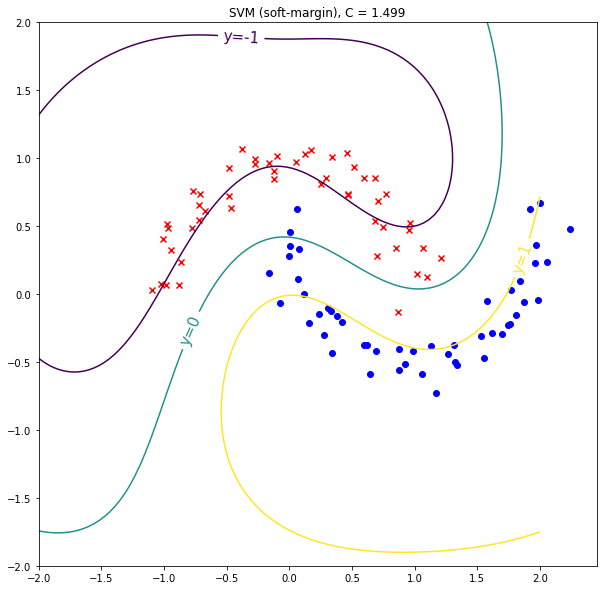

In [84]:

''' Implementing SVM hard margin '''
'''Converting second term of dual objective function into standard form, a.T*H*a for the optimizer'''
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape

C = float(input("Enter value of C"))
alphas = dualOptimizer(H,m,y,C)

#Selecting the set of indices S corresponding to non zero parameters
S = (alphas > 1e-4).flatten()

w = ((y[S] * alphas[S]).T @ X[S]).reshape(-1,1)

#Computing b
b = predb(y[S],alphas[S],X[S],X[S])

#Display results
print('Alphas: ',alphas,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b)

fig = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas[S],X[S],p,b)
#print(pr)


'''margin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')



cp = plt.contour(x0, x1, pred(y[S],alphas[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.title("SVM (soft-margin), C = " + str(C))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)
plt.savefig("SVM-soft-margin.jpg")